# Assignment 2: Tokenization, Word Embeddings, and Vector Algebra

## Introduction
In this assignment, we will explore the problem of getting from sequences of characters to wordtypes with different meanings. You will implement widely-used algorithms for tokenizing text and computing context-less word embeddings, and perform analysis on the results of running these algorithms.

Learning objectives:
* Understand how byte pair encoding works as a method for tokenizing character sequences, and how it differs from simpler tokenization methods like splitting on whitespace.
* Gain insights on how to compute and interpret language statistics, including Zipf's laws of word frequencies.
* Understand basics of distributional semantics, including basic implementations of word embedding algorithms.
* Learn to use vector algebra as a way of analyzing a space of word embeddings.

**Notes:**
* In your solution, keep all code as-is except where it's explicitly mentioned to implement a function.
* Items marked with a star (★) should be answered in a separate report as a text document with the corresponding item number. You will include your final report as a pdf with your submission.

**Submission:**

You will submit a single zip file `submission.zip` to Gradescope containing the following:

```
hw2.ipynb # your completed jupyter notebook
report.pdf # your written report
results/ # outputs from jupyter notebook
├── solve_analogy.json
├── W_en_fr.npy
├── W_en_ja.npy
└── ... (and all other generated files)
```

# Setup

Run the following cell to set up the helper function for saving your results. This function will create a directory called `results` and save the output of each of your implemented functions as a `.json` file inside.

In [1]:
import json
import os
from collections import Counter, defaultdict
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tokenizers import ByteLevelBPETokenizer
from tokenizers.normalizers import Lowercase

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

def save_results(results, filename):
    if not os.path.exists('results'):
        os.makedirs('results')
    with open(os.path.join('results', filename), "w") as f:
        json.dump(results, f, indent=4)

# Load the corpus
with open('data/stories.txt', 'r', encoding='utf-8') as f:
    en_corpus = [line.strip() for line in f.readlines()]

print(f"Loaded {len(en_corpus)} sentences.")
print("First 5 sentences:", en_corpus[:5])

Loaded 10000 sentences.
First 5 sentences: ['The Happy Prince.', 'HIGH above the city, on a tall column, stood the statue of the Happy Prince.  He was gilded all over with thin leaves of fine gold, for eyes he had two bright sapphires, and a large red ruby glowed on his sword-hilt.', 'He was very much admired indeed.  “He is as beautiful as a weathercock,” remarked one of the Town Councillors who wished to gain a reputation for having artistic tastes; “only not quite so useful,” he added, fearing lest people should think him unpractical, which he really was not.', '“Why can’t you be like the Happy Prince?” asked a sensible mother of her little boy who was crying for the moon.  “The Happy Prince never dreams of crying for anything.”', '“I am glad there is some one in the world who is quite happy,” muttered a disappointed man as he gazed at the wonderful statue.']


## Part 1: Tokenization (25 points)

In this part, you will implement two standard methods for tokenization to convert a sequence of characters into a sequence of tokens.

### Part 1.0: Setup
**Implement:** A helper function that, given a sequence of tokenized sentences, returns a dictionary pairing word types with their counts.

In [2]:
def count_word_types(tokenized_sentences: List[List[str]]) -> Dict[str, int]:
    """
    Given a list of tokenized sentences, return a dictionary mapping each word type to its frequency.
    """
    # TODO: Implement this function
    d = defaultdict(int)
    for sentence in tokenized_sentences:
        for token in sentence:
            d[token] += 1
    return d


word_counts_output = count_word_types(en_corpus)

### Part 1.1: Simple tokenization (10 points)
**Implement:** A function that splits a given input string by whitespace into sequences of tokens.

In [3]:
def simple_tokenize(text: str) -> List[str]:
    """
    Splits a given input string by whitespace into a sequence of tokens.
    """
    # TODO: Implement this function
    return text.split()

**Report:**

★ 1.1.1 Use the helper function to create a frequency dictionary for the sentences in `en_corpus`. What are the 10 most frequent wordtypes?

★ 1.1.2 What are two limitations you observe in this simple tokenization method? Include examples that motivate these limitations.

In [4]:
freq_dict = count_word_types(en_corpus)
sorted_freq_dict = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)
print(sorted_freq_dict[:10])
print(sum(freq_dict.values()))

[(' ', 558753), ('e', 291861), ('t', 208957), ('a', 182766), ('h', 176648), ('o', 166640), ('n', 150590), ('i', 133220), ('s', 126879), ('r', 119415)]
2938871


### Part 1.2: Byte pair encoding (15 points)
**Implement:** The Byte Pair Encoding (BPE) algorithm by completing the methods in the class below.

You'll need a few components:
1. A function to get pair frequencies from the vocabulary.
2. A function to merge a given pair in the vocabulary.
3. A main training function that iteratively finds the best pair and merges it.
4. A tokenizer function that applies the learned merges to new text.

In [5]:
# I've done the Stanford 336 Course by Percy Liang and Tatsu independently, so I referenced that when doing this.
class BPE():
    """Byte Pair Encoding (BPE) tokenizer."""
    
    def __init__(self):
        """Initializes the BPE tokenizer.

        Attributes:
            merges (dict[tuple(str), str]): Dictionary mapping pairs of tuples to their merged symbol.
            vocab (dict[int, str]): Dictionary mapping integer ids to their corresponding tokens.
        """
        self.merges = {}
        self.vocab = {}

    def get_stats(self, word_freqs: Counter[str]) -> Counter[tuple[str, str]]:
        """Counts the frequency of pairs in the vocabulary.

        Args:
            word_freqs: Counter[str]
        
        Returns:
            Counter[tuple[str, str]] representing the frequency of each pair in the vocabulary.
        """
        # TODO: Implement this function
        pair_counts = Counter()
        for word in word_freqs.keys():
            word_tokens = word.split()
            for i in range(len(word_tokens)-1):
                pair_counts[(word_tokens[i], word_tokens[i+1])] += word_freqs[word]
        return pair_counts
    
    def get_most_frequent_pair(self, pair_counts: Counter[tuple[str, str]]) -> tuple[str, str]:
        """Helper function to get the most frequent pair from the pair counts.

        Args:
            pair_counts (Counter[tuple[str, str]]): Counter object containing the frequency of each pair in the vocabulary.
        
        Returns:
            tuple[str, str] representing the most frequent pair in the vocabulary.
        """
        return max(pair_counts.items(), key=lambda x: x[1])[0]

    def merge(self, pair: tuple[str, str], word_freqs: Counter[str]) -> None:
        """Merges a pair of symbols into a new symbol in the vocabulary.

        Args:
            pair (tuple[str, str]): Pair of symbols to merge.
            word_freqs (Counter[str]): Counter object containing the frequency of each word in the vocabulary.
        
        Outputs:
            None, but updates the word_freqs counter to reflect the new symbol.
        """
        merged_token = pair[0] + pair[1]
        
        self.vocab[len(self.vocab)] = merged_token
        self.merges[pair] = merged_token
        
        new_word_freqs = Counter()
        for word, freq in word_freqs.items():
            tokens = word.split()
            new_tokens = []
            i = 0
            while i < len(tokens):
                if i < len(tokens) - 1 and tokens[i] == pair[0] and tokens[i+1] == pair[1]:
                    new_tokens.append(merged_token)
                    i += 2
                else:
                    new_tokens.append(tokens[i])
                    i += 1
            new_word = ' '.join(new_tokens)
            new_word_freqs[new_word] += freq
        
        word_freqs.clear()
        word_freqs.update(new_word_freqs)


    def train(self, corpus: list[str], vocab_size: int):
        """Trains the tokenizer on a given corpus.
        
        Args:
            corpus (list[str]): Corpus containing a list of sentences.
            vocab_size (int): Maximum size of the vocabulary.
        
        Returns:
            ???
        """

        # 1. Initialize vocabulary and pre-tokenize the corpus
        initial_vocab = set()
        word_freqs = defaultdict(int)
        
        # Prepare the initial word frequency map
        for text in corpus:
            words = text.strip().split()
            for word in words:
                processed_word = ' '.join(list(word))
                word_freqs[processed_word] += 1
                initial_vocab.update(list(word))

        # The initial vocabulary includes all single characters
        self.vocab = {i: char for i, char in enumerate(sorted(list(initial_vocab)))}

        # 2. Iteratively merge the most frequent pair
        # TODO: Implement this function

        while len(self.vocab) < vocab_size:
            most_frequent_pair = self.get_most_frequent_pair(self.get_stats(word_freqs))
            self.merge(most_frequent_pair, word_freqs)
        return self.vocab

    def tokenize(self, text: str) -> list[str]:
        """Tokenizes a new sentence using the learned merge rules."""
        # TODO: Implement this function
        words = text.split()
        tokenized_words = []
        
        for word in words:
            tokens = list(word)
            
            for pair, merged_token in self.merges.items():
                new_tokens = []
                i = 0
                while i < len(tokens):
                    if i < len(tokens) - 1 and tokens[i] == pair[0] and tokens[i+1] == pair[1]:
                        new_tokens.append(merged_token)
                        i += 2
                    else:
                        new_tokens.append(tokens[i])
                        i += 1
                tokens = new_tokens
            
            tokenized_words.extend(tokens)
        
        return tokenized_words

    def decode(self, tokens: list[str]) -> str:
        """Decodes a sequence of tokens back into a string."""
        # TODO: Implement this function
        return ''.join(tokens)

#### 💾 Save your results for `BPE`

In [6]:
bpe_tokenizer = BPE()
bpe_tokenizer.train(en_corpus, vocab_size=500)

# Save the learned merges and vocabulary
save_results({str(k): v for k, v in bpe_tokenizer.merges.items()}, 'bpe_merges.json')
save_results(bpe_tokenizer.vocab, 'bpe_vocab.json')
print("Saved results for BPE merges and vocabulary.")

Saved results for BPE merges and vocabulary.


**Report:**

★ 1.2.1 What are the 10 most frequent wordtypes from your BPE tokenizer?

★ 1.2.2 Generate a plot showing the Zipfian distribution of wordtypes (i.e., a log-log plot of frequency vs. rank). Compare the distributions from simple whitespace tokenization and BPE. Include the plots and your comparison in the report, make sure your plot is clearly labeled.

★ 1.2.3 Why might these distributions look different from one another?

In [7]:
# TODO: Use this space to generate your Zipfian plot.
tokenized_corpus = [bpe_tokenizer.tokenize(sentence) for sentence in en_corpus]
all_tokens = [token for sentence in tokenized_corpus for token in sentence]
token_counts = Counter(all_tokens)
most_common_tokens = token_counts.most_common(10)

print("10 most frequent:")
for token, count in most_common_tokens:
    print(f"Token: {token}, Frequency: {count}")

10 most frequent:
Token: the, Frequency: 35285
Token: ,, Frequency: 30195
Token: and, Frequency: 26701
Token: s, Frequency: 20350
Token: a, Frequency: 17928
Token: to, Frequency: 17864
Token: ., Frequency: 15017
Token: t, Frequency: 14150
Token: he, Frequency: 12738
Token: in, Frequency: 11956


In [8]:
# Simple whitespace tokenization
simple_tokenized_corpus = [simple_tokenize(sentence) for sentence in en_corpus]
simple_all_tokens = [token for sentence in simple_tokenized_corpus for token in sentence]
simple_token_counts = Counter(simple_all_tokens)

Text(0.5, 1.0, 'Simple Encoding Zipfian Distribution')

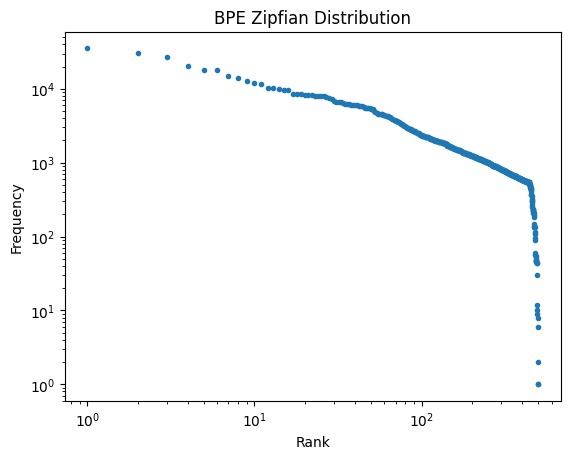

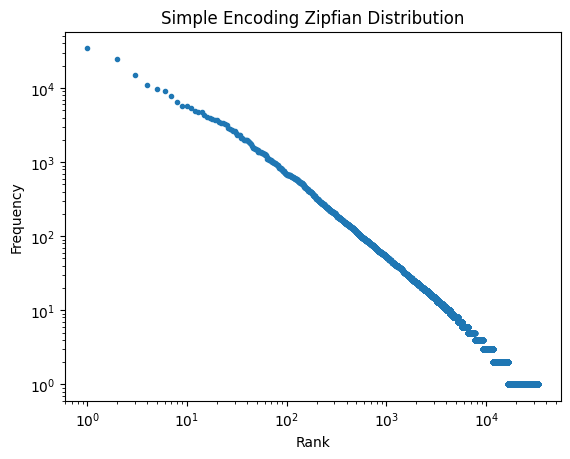

In [14]:
# Plotting
bpe_counts = np.array(sorted(token_counts.values(), reverse=True), dtype=float)
bpe_ranks = np.arange(1, len(bpe_counts) + 1, dtype=float)

plt.figure()
plt.loglog(bpe_ranks, bpe_counts, marker='.', linestyle='none') # got a bit of help from chatGPT for how to plot the log-log relationship
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("BPE Zipfian Distribution")

simple_counts = np.array(sorted(simple_token_counts.values(), reverse=True), dtype=float)
simple_ranks = np.arange(1, len(simple_counts) + 1, dtype=float)

plt.figure()
plt.loglog(simple_ranks, simple_counts, marker='.', linestyle='none') # got a bit of help from chatGPT for how to plot the log-log relationship
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("Simple Encoding Zipfian Distribution")

## Part 2: Word embeddings (25 points)

In this part, you will implement the Skip-Gram model to compute word embeddings for the words in your corpus.

### Part 2.0: Setup
For the remainder of the assignment, we will use `ByteLevelBPETokenizer` from the `tokenizers` library. 

In [15]:
def get_tokenizer(data_path: str, vocab_size=10000):
    tokenizer = ByteLevelBPETokenizer()
    tokenizer.normalizer = Lowercase()

    tokenizer.train(files=data_path, vocab_size=vocab_size, min_frequency=2)

    return tokenizer

en_tokenizer = get_tokenizer("data/stories.txt")
en_tokenized = [en_tokenizer.encode(s).ids for s in en_corpus]

### Part 2.1: Experiment with different contexts (5 points)

First, let's explore different implementations of context for the Skip-Gram model.

**Implement:** Two functions that map from tokenized sentences and words to contexts:

##### a)  **Bag-of-Words Context** 
The first function should, for each target token $w$, create a positive example $(w, c)$ for every additional token $c$ in the sentence. 

I.e., for a sentence $\langle x_1, \dots, x_m \rangle$ of length $m$ tokens, we should create $m \cdot (m - 1)$ positive examples: $\bigcup_{1 \leq i \leq m} \bigcup_{1 \leq j \leq m, i \neq j} \left\{ (x_i, x_j) \right\}$.
   
##### b)  **Neighboring Tokens Context** 

The second function should, for each target token $w$, create a positive example $(w, c)$ for each of the tokens within a window of up to size $N$ before and after the target token's index. 

I.e., for a sentence $\langle x_1, \dots, x_m \rangle$ of length $m$ tokens, we should create $m \cdot 2N$ positive examples: $\bigcup_{1 \leq i \leq m}\bigcup_{1 \leq j \leq N}\{ (x_i, (-j, x_{i-j})), (x_i, (j, x_{i + j}) )\}$. 

Here, contexts are  not just individual wordtypes, but the wordtypes are paired with some positive or negative distance away from the target token. For cases where the window is out of bounds of the sentence (i.e., $i - j < 1$ or $i + j > m$), you can create a special wordtype (e.g., \<BOS\> or \<EOS\>).

In [17]:
def get_bow_context(tokenized_sentences: List[List[str]]) -> List[Tuple[int, int]]:
    """
    Creates positive (target, context) examples where context is any other word in the sentence.
    NOTE: this is modified to return ints, as according to the Ed clarifications.
    """
    # TODO: Implement this function
    out_context = []
    for sentence in tokenized_sentences:
        for i in range(len(sentence)):
            for j in range(len(sentence)):
                if i != j:
                    out_context.append((sentence[i], sentence[j]))
    return out_context


def get_neighbor_context(tokenized_sentences: List[List[int]], window_size: int) -> List[Tuple[int, int]]:
    """
    Creates positive (target, context) examples from tokens within a given window size.
    """
    # TODO: Implement this function
    out_context = []
    for sentence in tokenized_sentences:
        for i in range(len(sentence)):
            for j in range(1, window_size+1):
                ctx_left_idx = i - j
                ctx_right_idx = i + j
                if ctx_left_idx >= 0:
                    out_context.append((sentence[i], sentence[ctx_left_idx]))
                if ctx_right_idx < len(sentence):
                    out_context.append((sentence[i], sentence[ctx_right_idx]))
    return out_context
    

#### 💾 Save your results for `get_neighbor_context`

In [18]:
neighbor_pairs = get_neighbor_context(en_tokenized, window_size=2)
save_results(neighbor_pairs[:10000], 'neighbor_context.json')
print("Saved results for get_neighbor_context.")

Saved results for get_neighbor_context.


### Part 2.3: Negative sampling (5 points)
To train the Skip-Gram model efficiently, we use negative sampling. First, we model the probability distribution over contexts.

**Implement:** A function that computes a distribution over the contexts $\mathcal{C}$ given a dataset of word-context pairs $\mathcal{D}$.

In [19]:
def get_context_distribution(pairs: List[Tuple[int, int]], vocab_size: int) -> List[float]:
    """
    Computes the probability distribution over contexts P(c).

    Args:
        pairs: A list of (token, context) pairs.
        vocab_size: The size of the vocabulary.

    Returns:
        A list of probabilities for each context token, ordered by token index.
    """
    # TODO: Implement this function
    context_distribution = [0] * vocab_size
    for pair in pairs:
        context_distribution[pair[1]] += 1
    context_distribution = [x / len(pairs) for x in context_distribution]
    return torch.tensor(context_distribution)


**Implement:** A function for sampling negative pairs of tokens and contexts given the prior over contexts $\mathcal{C}$.

In [20]:

def sample_negative_contexts(context_distribution: torch.Tensor, num_samples: int, batch_size=1) -> torch.Tensor:
    """
    Samples negative contexts based on the context distribution.
    """
    # TODO: Implement this function
    # context_distribution = context_distribution / context_distribution.sum()
    # batched_distribution = context_distribution.repeat(batch_size, 1)
    batched_distribution = context_distribution.expand(batch_size, -1)
    return torch.multinomial(batched_distribution, num_samples, replacement=True)


**Report:**

★ 2.3.1 For each of the following context settings, list the highest-probability *negative* sample according to the priors you computed:
- Context as a bag of words.
- Context as neighboring tokens, $N=1$.
- Context as neighboring tokens, $N=2$.

In [ ]:
# NOTE: Scratch work here
# Neighboring N=1
neighbor_pairs = get_neighbor_context(en_tokenized, window_size=2)
ctx_dist = get_context_distribution(neighbor_pairs, len(en_tokenizer.get_vocab()))
samples = sample_negative_contexts(ctx_dist, 10000, 1)
highest_prob_token = torch.argmax(ctx_dist)
print(en_tokenizer.decode([highest_prob_token]))

# Neighboring N=2
neighbor_pairs = get_neighbor_context(en_tokenized, window_size=1)
ctx_dist = get_context_distribution(neighbor_pairs, len(en_tokenizer.get_vocab()))
samples = sample_negative_contexts(ctx_dist, 10000, 1)
highest_prob_token = torch.argmax(ctx_dist)
print(en_tokenizer.decode([highest_prob_token]))

# BOW
neighbor_pairs = get_bow_context(en_tokenized)
ctx_dist = get_context_distribution(neighbor_pairs, len(en_tokenizer.get_vocab()))
samples = sample_negative_contexts(ctx_dist, 10000, 1)
highest_prob_token = torch.argmax(ctx_dist)
print(en_tokenizer.decode([highest_prob_token]))

,
,
,


### Part 2.4: Train the Skip-Gram model and analyze embeddings (15 points)

Now, we'll define our Skip-Gram model and train it on our corpus.

**Implement:** A Skip-Gram model in PyTorch. The model should consist of two embedding layers: one for the target words and one for the context words.

In [21]:
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int):
        super(SkipGramModel, self).__init__()
        # TODO: Implement the model layers
        self.target_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.output_embeddings = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, target, context):
        # TODO: Implement the forward pass
        # targets should be (B, 1)
        # context should be (B, K)
        if target.dim() == 1:
            target = target.unsqueeze(1)
        target_embeds = self.target_embeddings(target) # (B, 1, D)
        context_embeds = self.output_embeddings(context) # (B, K, D)
        # return torch.sum(target_embeds.unsqueeze(1) * context_embeds, dim=-1) # (B, K)
        return torch.sum(target_embeds * context_embeds, dim=-1) # (B, K)
        


**Implement:** Train your Skip-Gram model using the tokenized data `en_tokenized`. You may want to implement batching to speed things up.


In [22]:
# from tqdm import tqdm
device = 'cuda'

class SkipGramDataset(Dataset):
    def __init__(self, pairs: List[Tuple[int, int]]):
        self.pairs = pairs
        
    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.pairs[idx]

def train_skipgram(corpus, tokenizer, num_epochs=30):

    # Initialize the model, loss function, optimizer, and dataloader

    embedding_dim = 128
    vocab_size = len(tokenizer.get_vocab())
    model = SkipGramModel(vocab_size, embedding_dim).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    batch_size = 2**16

    neighbor_pairs = get_neighbor_context([tokenizer.encode(s).ids for s in corpus], window_size=5)
    dataset = SkipGramDataset(neighbor_pairs)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
    )    

    # Training loop
    # TODO: Implement this. 
    # You will need to combine positive and negative samples in the loss computation, and adjust the labels accordingly.
    NUM_NEGATIVE_SAMPLES = 31
    context_dist = get_context_distribution(neighbor_pairs, vocab_size)

    # if not os.path.exists('cached_neg_ctx.pt'):
        # print("CACHING")
        # cached_neg_ctx = []
        # for step, batch in enumerate(tqdm(dataloader)):
            # neg_ctx = sample_negative_contexts(context_dist, NUM_NEGATIVE_SAMPLES, batch_size) # (B, K-1)
            # cached_neg_ctx.append(neg_ctx)
        # cached_neg_ctx = torch.stack(cached_neg_ctx, dim=0)
        # torch.save(cached_neg_ctx, 'cached_neg_ctx.pt')
        # print("finished caching") 
        # print(f"cached_neg_ctx.shape: {cached_neg_ctx.shape}")
    # else:
        # cached_neg_ctx = torch.load('cached_neg_ctx.pt')
        # print("loaded cached negative contexts")
        # print(f"cached_neg_ctx.shape: {cached_neg_ctx.shape}")



    model.train()
    step = 0
    for epoch in range(num_epochs):
        for step, batch in enumerate(tqdm(dataloader)):
            target, positive_context = batch

            # cached_neg_ctx_step = cached_neg_ctx[torch.randperm(cached_neg_ctx.size(0))]
            # negative_contexts = cached_neg_ctx[step]
            negative_contexts = sample_negative_contexts(context_dist, NUM_NEGATIVE_SAMPLES, target.shape[0]) # (B, K-1)

            target = target.unsqueeze(1).to(device) # (B, 1)
            positive_context = positive_context.unsqueeze(1) # (B, 1)
            full_context = torch.cat([positive_context, negative_contexts], dim=-1).to(device) # (B, K)

            scores = model(target, full_context) # (B, K)
            labels = torch.zeros_like(scores, dtype=torch.float, device=device)
            labels[:, 0] = 1.0
            labels = labels.to(device)
            loss = criterion(scores, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if step % 100 == 0:
                print(f"Loss: {loss.item()}")
        print(f"EPOCH {epoch+1} COMPLETED")
    return model

#### 💾 Save your model outputs

In [23]:
device = 'cuda'


# model = train_skipgram(en_corpus, en_tokenizer, num_epochs=30)
# model = train_skipgram(en_corpus, en_tokenizer, num_epochs=1)
# torch.save(model.state_dict(), 'results/skipgram_model.pth')
with open('results/skipgram_model.pth', 'rb') as f:
    model.load_state_dict(torch.load(f))
    model.to(device)
    model.eval()

test_center_word = torch.tensor(np.load('data/center_word.npy')).to(device)
test_context_words = torch.tensor(np.load('data/context_words.npy')).to(device)
print(test_center_word.shape, test_context_words.shape)

test_scores = model(test_center_word, test_context_words)
np.save('results/skipgram_scores.npy', test_scores.cpu().detach().numpy())

FileNotFoundError: [Errno 2] No such file or directory: 'results/skipgram_model.pth'

**Implement:** A function that, given a trained Skip-Gram model and a target wordtype, returns the cosine similarity of that wordtype's embedding with the embedding of every other wordtype in the vocabulary.

In [89]:
def get_cosine_similarity(model: SkipGramModel, tokenizer: ByteLevelBPETokenizer, target_word: str) -> List[Tuple[str, float]]:
    """
    Given a trained model and a target word, returns a list of (word, similarity_score) 
    for all words in the vocabulary (excluding the target word), sorted by similarity score.
    """
    # TODO: Implement this function
    embedding_matrix = model.target_embeddings.weight.detach() # (V, D)
    # print(embedding_matrix.shape)
    vocab = tokenizer.get_vocab()
    # target_id = vocab[target_word]
    # target_embed = embedding_matrix[target_id] # (D)
    target_ids = tokenizer.encode(target_word).ids
    # print(target_ids)
    embeddings = embedding_matrix[target_ids]
    # print(embeddings.shape)
    target_embed = torch.mean(embeddings, dim=0)
    # print(target_embed.shape)

    norm_target_embed = target_embed / torch.norm(target_embed)
    norm_embed_matrix = embedding_matrix / torch.norm(embedding_matrix, dim=1, keepdim=True)

    print(norm_target_embed.shape, norm_embed_matrix.shape)

    sims = (norm_embed_matrix @ norm_target_embed.unsqueeze(1)).flatten() # (V, D) x (D, 1) = (V, 1) -> (V)
    # for target_id in target_ids:
        # sims[target_id] = float("-inf")

    out_list = []
    for i, sim in enumerate(sims):
        # if i != target_id:
            # out_list.append((tokenizer.decode([i]), float(sim)))
        decoded = tokenizer.decode([i])
        if decoded != target_word:
            out_list.append((decoded, float(sim)))
    out_list.sort(key=lambda x: x[1], reverse=True)
    return out_list


**Report:**

★ 2.4.1 Use `get_cosine_similarity` to explore similar wordtypes for different English words. Give three examples of pairs of similar wordtypes that make sense, and three that don't. What are possible reasons for a high similarity score between two seemingly unrelated words?

In [100]:
model = SkipGramModel(en_tokenizer.get_vocab_size(), 128).to(device)
with open('skipgram_model.pth', 'rb') as f:
    model.load_state_dict(torch.load(f))
    model.to(device)
    model.eval()


out_list = get_cosine_similarity(model, en_tokenizer, "house")
print(out_list[:20])

out_list = get_cosine_similarity(model, en_tokenizer, "dog")
print(out_list[:20])

out_list = get_cosine_similarity(model, en_tokenizer, "apple")
print(out_list[:20])


# en_tokenizer.encode("reasefasdf").ids

torch.Size([128]) torch.Size([10000, 128])
[(' below', 0.4845505952835083), ('pot', 0.4338051378726959), (' service', 0.4332274794578552), (' didst', 0.43233466148376465), (' across', 0.4288783669471741), (' sitting', 0.42273595929145813), (' involuntarily', 0.4221460521221161), ('an', 0.4219568073749542), ('man', 0.4160875678062439), (' cousin', 0.40734925866127014), ('-', 0.4064388871192932), ('pend', 0.40512409806251526), (' rush', 0.404011607170105), (' opened', 0.40097302198410034), (' friends', 0.4005701541900635), (' bunch', 0.3997534215450287), ('well', 0.39963024854660034), (' departure', 0.3995365798473358), (' during', 0.3987198770046234), (' lie', 0.3965262472629547)]
torch.Size([128]) torch.Size([10000, 128])
[(' insisted', 0.45965734124183655), (' lap', 0.4458067715167999), (' grave', 0.443704217672348), (' hour', 0.4327261447906494), ('has', 0.43020695447921753), (' immortal', 0.4261927306652069), (' changeling', 0.42061591148376465), (' bestowed', 0.4184361398220062), (

## Part 3: Vector algebra (25 points)

For the remainder of this homework, you will use a modern NLP library `spaCy`. You can find its documentation [here](https://spacy.io/usage/spacy-101).

Install spaCy and its English, French, Japanese models with
```
pip install spacy
python -m spacy download en_core_web_md
python -m spacy download fr_core_news_md
python -m spacy download ja_core_news_md
```


### Part 3.0: Setup

In [101]:
import spacy

nlp_en = spacy.load("en_core_web_md")
nlp_fr = spacy.load("fr_core_news_md")
nlp_ja = spacy.load("ja_core_news_md")

### Part 3.1: Word analogy (10 points)

**Implement:** A function that, given two wordtypes representing a target analogy (e.g., *cat* and *kitten*) and an input wordtype to evaluate in that analogy (e.g., *dog*), returns the wordtype that (according to the learned embeddings) best fits as the analogy. Recall the formula for finding this in the slides.

In [102]:
# dir(nlp_en)
# print(nlp_en.tokenizer)
print(nlp_en.vocab.vectors.data.shape)
# nlp_en.vocab["test"].vector.shape
# len(nlp_en.vocab)

(20000, 300)


In [105]:
# Referred to spaCy documentation at https://spacy.io/api/lexeme and the function afterwards.
# Also looked at some tips on EdStem
# Asked chatGPT for how to Argsort
def solve_analogy(model, a: str, b: str, c: str, n=5) -> str:
    """
    Solves the analogy 'a is to b as c is to ?'.
    Returns the word from the vocabulary whose embedding is closest to vec(b) - vec(a) + vec(c).
    """
    # TODO: Implement this function
    a_emb = model.vocab[a].vector # [D, ]
    b_emb = model.vocab[b].vector 
    c_emb = model.vocab[c].vector
    target = b_emb - a_emb + c_emb # [D, ]

    norm_target = target / (np.linalg.norm(target))

    embedding = nlp_en.vocab.vectors.data # [V, D]
    norm_embedding = embedding / (np.linalg.norm(embedding, axis=1, keepdims=True))

    sims = norm_embedding @ norm_target
    # print(sims.shape)
    # max_sim = np.argmax(sims)
    top_indices = np.argsort(-sims)[:n]
    for idx in top_indices:
        # print(idx)
        key = list(model.vocab.vectors.keys())[idx]
        top_word = model.vocab.strings[key]
        if top_word not in [a, b, c]:
            return top_word
    return None

#### 💾 Save your results for `solve_analogy`

In [106]:
test_analogies = [
    ("king", "queen", "man", "woman"),
    ("paris", "france", "berlin", "germany"),
    ("car", "driver", "train", "conductor"),
    ("good", "better", "bad", "worse"),
    ("big", "bigger", "small", "smaller"),
    ("dog", "puppy", "cat", "kitty"),
]


analogy_results = []
for a, b, c, expected in test_analogies:
    result = solve_analogy(nlp_en, a, b, c)
    analogy_results.append(result)
    print(f"{a}:{b}::{c}:? -> {result} (expected: {expected})")

save_results(analogy_results, 'solve_analogy.json')

king:queen::man:? -> lady (expected: woman)
paris:france::berlin:? -> Berlin (expected: germany)
car:driver::train:? -> trains (expected: conductor)
good:better::bad:? -> worse (expected: worse)
big:bigger::small:? -> smaller (expected: smaller)
dog:puppy::cat:? -> kitty (expected: kitty)


**Report:**

★ 3.1.1 Find three analogies in English that the model is able to solve correctly, and three analogies in English where the model gives a wrong answer.

In [113]:
test_analogies = [
    ("hot", "cold", "big", "small"),
    ("egypt", "africa", "china", "asia"),
    ("child", "parent", "student", "teacher"),
    ("cool", "coolest", "big", "biggest"),
    ("wide", "wider", "tall", "taller"),
    ("mother", "father", "grandmother", "grandfather"),

]


analogy_results = []
for a, b, c, expected in test_analogies:
    result = solve_analogy(nlp_en, a, b, c)
    analogy_results.append(result)
    print(f"{a}:{b}::{c}:? -> {result} (expected: {expected})")

save_results(analogy_results, 'solve_analogy.json')

hot:cold::big:? -> huge (expected: small)
egypt:africa::china:? -> india (expected: asia)
child:parent::student:? -> faculty (expected: teacher)
cool:coolest::big:? -> biggest (expected: biggest)
wide:wider::tall:? -> taller (expected: taller)
mother:father::grandmother:? -> grandfather (expected: grandfather)


### 3.2 Embedding alignment (15 points)

**Implement:** A function that identifies the transformation $W$ that best aligns two embedding spaces given a parallel corpus and a parallel word.

In [21]:
from spacy.language import Language

def learn_translation_matrix(
    nlp_src: Language,
    nlp_tgt: Language,
    word_pairs: List[List[str]]
) -> np.ndarray:
    """
    Learns a linear transformation matrix W that maps source language vectors to target language vectors.
    Input:
        nlp_src: spaCy Language object for the source language.
        nlp_tgt: spaCy Language object for the target language.
        word_pairs: A list of [source_word, target_word] pairs.
    Output:
        W: A numpy array of shape (d, d) where d is the embedding dimension
    """

    # 1. Create the training matrices X (Source) and Y (Target)
    X_list = []
    Y_list = []
    for src_word, tgt_word in word_pairs:
        if nlp_src.vocab[src_word].has_vector and nlp_tgt.vocab[tgt_word].has_vector:
            # Normalize vectors to focus on direction
            src_vector = nlp_src.vocab[src_word].vector
            tgt_vector = nlp_tgt.vocab[tgt_word].vector
            X_list.append(src_vector / np.linalg.norm(src_vector))
            Y_list.append(tgt_vector / np.linalg.norm(tgt_vector))

    X = np.array(X_list)
    Y = np.array(Y_list)
    
    # 2. Learn the transformation matrix W where WX ≈ Y
    # TODO: Implement this
    # B, *_ = np.linalg.lstsq(X, Y, rcond=None)
    # W = B.T
    # return W
    # M = X.T @ Y
    M = Y.T @ X
    U, _, V = np.linalg.svd(M, full_matrices=False)
    W = U @ V
    # W = V @ U.T
    return W



def translate_with_matrix(
    nlp_src: Language, nlp_tgt: Language, W: np.ndarray, word: str
):
    """
    Translates a word from the source language to the target language using the learned matrix W.
    Input:
        nlp_src: spaCy Language object for the source language.
        nlp_tgt: spaCy Language object for the target language.
        W: The learned transformation matrix.
        word: The source language word to translate.
    Output:
        predicted_word: The translated word in the target language.
    """
    src_vec = nlp_src.vocab[word].vector
    src_vec_norm = src_vec / np.linalg.norm(src_vec)

    tgt_vec_pred = W @ src_vec_norm
    tgt_vec_pred_norm = tgt_vec_pred / np.linalg.norm(tgt_vec_pred)

    all_tgt_vectors = nlp_tgt.vocab.vectors.data
    all_tgt_vectors_norm = all_tgt_vectors / np.linalg.norm(all_tgt_vectors, axis=1, keepdims=True)

    similarities = np.dot(all_tgt_vectors_norm, tgt_vec_pred_norm)
    best_match_index = np.argmax(similarities)

    hash_value = list(nlp_tgt.vocab.vectors.keys())[best_match_index]
    predicted_word = nlp_tgt.vocab.strings[hash_value]
    return predicted_word



#### 💾 Save your results for `learn_translation_matrix`

In [22]:
en_ja = json.load(open('data/en-ja.json'))
en_fr = json.load(open('data/en-fr.json'))

W_en_fr = learn_translation_matrix(nlp_en, nlp_fr, en_fr)
W_en_ja = learn_translation_matrix(nlp_en, nlp_ja, en_ja)

# Save your matrices
np.save('results/W_en_fr.npy', W_en_fr)
np.save('results/W_en_ja.npy', W_en_ja)
print("Saved translation matrices.")

Saved translation matrices.


**Report:** Generate transformation matrices to translate between English<->Japanese and English<->French.

★ 3.2.1 What happens when you translate each of these English words to Japanese/French, then back to English?

1. penguin
2. cheese
3. sofa
4. jacket
5. website

In [23]:
en_words = [
    "penguin",
    "cheese",
    "sofa",
    "jacket",
    "website"
]

# TODO: Use this space to translate the words above using your learned matrices.
print("==== JAPANESE ====")
jp_words = [translate_with_matrix(nlp_en, nlp_ja, W_en_ja, word) for word in en_words]
jp_to_en_words = [translate_with_matrix(nlp_ja, nlp_en, W_en_ja.T, word) for word in jp_words]
for a, b, c in zip(en_words, jp_words, jp_to_en_words):
    print(f"{a} -> {b} -> {c}")
print("==== FRENCH ====")
fr_words = [translate_with_matrix(nlp_en, nlp_fr, W_en_fr, word) for word in en_words]
fr_to_en_words = [translate_with_matrix(nlp_fr, nlp_en, W_en_fr.T, word) for word in fr_words]
for a, b, c in zip(en_words, fr_words, fr_to_en_words):
    print(f"{a} -> {b} -> {c}")


==== JAPANESE ====
penguin -> 蛙 -> snakes
cheese -> 美味しい -> delicious
sofa -> ソファー -> sofa
jacket -> 上着 -> jacket
website -> ホームページ -> website
==== FRENCH ====
penguin -> tortue -> turtle
cheese -> fromage -> cheese
sofa -> canapé -> sofa
jacket -> pantalon -> jacket
website -> internet -> internet


## Part 4: Computational linguistics (25 points)

In this part, you will use `spaCy` to perform linguistic analysis on our corpus. 

Use the English model from spaCy `nlp_en` to:

(a) tokenize
(b) lemmatize
(c) get dependency trees 

the first 1000 sentences in our corpus `en_corpus`.

**Report:**

A *lemma* is the canonical or dictionary form of a word, representing the base from which all its inflected forms are derived. In NLP, the process of lemmatization groups these various forms (e.g., ran, runs, running) under their single shared lemma (run) to normalize text and simplify analysis.

★ 4.1.1 Report the 10 most frequent verb lemmas in the corpus.

★ 4.1.2 For the top 5 most frequent verb lemmas, show the distribution of their subject lemmas (i.e. by navigating the dependency tree from the root to find the `nsubj` item).

★ 4.1.3 Based on your findings, do you observe any relationship between the types of verbs and the types of subjects they take (e.g., are certain verbs more likely to have animate subjects like 'man' or 'I', versus inanimate subjects like 'door' or 'it')? Discuss one interesting example.

In [ ]:
en_corpus_mini = en_corpus[:1000]

# TODO: Use spaCy to answer the following questions.


## Part 5: Bonus: Language puzzles (10 points)

The following sentences are from a perturbed version of a real language, presented alongside their translations into English. Your task is to match each phrase in **Language Y** with its correct **English** translation.

|   | Language Y                     |   | English                  |
|---|--------------------------------|---|--------------------------|
| A | he shege ptauege yaijeech      | 1 | the cousin's teacher     |
| B | heau shege yaijeege stauyau    | 2 | the nurses' cousin       |
| C | heau shai ugheedai hyoogeshyau | 3 | the architects' teachers |
| D | heau shege eegeege oogheedyau  | 4 | the schools' architect   |
| E | he shai stauai eegeech         | 5 | the teachers' schools    |
| F | he shai yausai stauich         | 6 | the managers' tools      |
| G | he shege hyoogesheege yauseech | 7 | the manager's nurses     |
| H | heau shege staueege ptauyau    | 8 | the professor's tool     |

**Your Answer:**

★ Provide your final matching (e.g., A-1, B-2, C-3, ...). Briefly explain the logic you used to decipher the language, including how possession (e.g., 's) and plurals are marked.

## Academic integrity

You can discuss high-level solutions with classmates, but your submitted work should be your own. Don't copy from or share code with one another. Provide attribution for any sources of assistance you used in the assignment. If you use generative AI tools to aid in any parts of this assignment, describe how you used them and what worked (or didn't work) when using them.